In [1]:
import os
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.multiclass import unique_labels

import tensorflow

import keras
from keras.models import Model
from keras.layers import Input, Flatten, Conv2D, MaxPool2D, Dense, BatchNormalization, Dropout, AlphaDropout
from keras.optimizers import Adam, RMSprop, Nadam
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard as TensorBoardCallback
from keras.utils import to_categorical

# Fashion Classification

<img src="https://raw.githubusercontent.com/roma-glushko/zelando-fashion-mnist/master/doc/fashion-mnist.png" width="600px" />

In [2]:
RANDOM_SEED = 20210116

np.random.seed(RANDOM_SEED)
tensorflow.random.set_seed(RANDOM_SEED)

In [3]:
train_df = pd.read_csv('data/fashion-mnist_train.csv')
test_df = pd.read_csv('data/fashion-mnist_test.csv')

# Dataset Overview

In [4]:
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
X_train, y_train = train_df.drop(['label'], axis=1), train_df['label']
X_test, y_test = test_df.drop(['label'], axis=1), test_df['label']

<AxesSubplot:xlabel='label', ylabel='Count'>

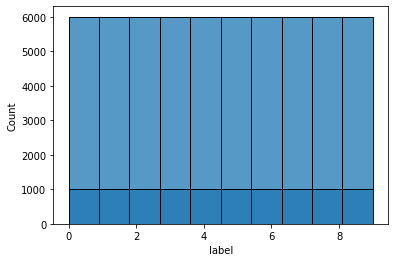

In [6]:
sns.histplot(data=y_train, bins=10)
sns.histplot(data=y_test, bins=10)

In [7]:
X_train = X_train / 255.0
X_test = X_test / 255.0

In [8]:
val_splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=RANDOM_SEED)

for train_idx, val_idx in val_splitter.split(X_train, y_train):
    X_train_val, y_train_val = X_train.iloc[train_idx], y_train.iloc[train_idx]
    X_val, y_val = X_train.iloc[val_idx], y_train.iloc[val_idx]

In [9]:
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.001, random_state=RANDOM_SEED)

for _, val_idx in splitter.split(X_train, y_train):
    X_train_overfit, y_train_overfit = X_train.iloc[val_idx], y_train.iloc[val_idx]

In [10]:
label_names = [
    'T-shirt/Top',
    'Trouser',
    'Pullover',
    'Dress',
    'Coat',
    'Sandal',
    'Shirt',
    'Sneaker',
    'Bag',
    'Ankle boot',
]

label_num = len(label_names)

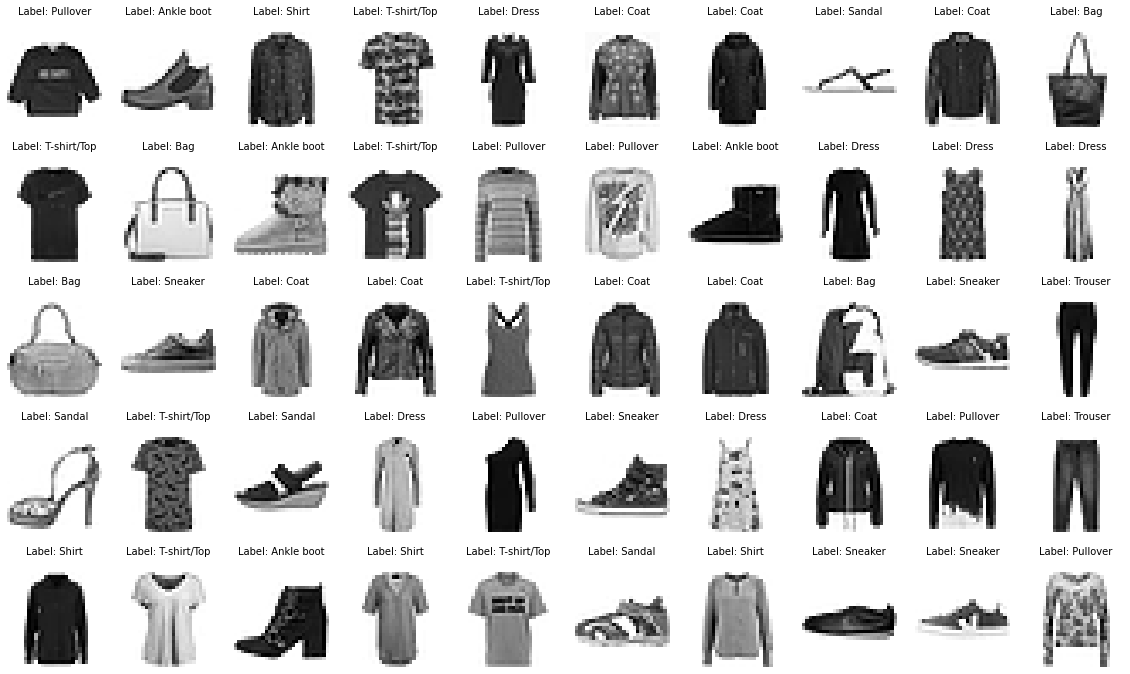

In [11]:
plt.figure(figsize=(20, 12))

for index, (image, label_idx) in enumerate(zip(X_train[0:50], y_train[0:50])):
    label = label_names[label_idx]

    ax = plt.subplot(5, 10, index + 1)
    ax.axis('off')

    plt.imshow(np.reshape(X_train.values[index], (28, 28)), cmap='binary')

    plt.title('Label: %s\n' % label, fontsize=10);

# Classification

In [12]:
def plot_confusion_matrix_by_predictions(y_true, y_predicted, *, labels=None,
                          sample_weight=None, normalize=None,
                          display_labels=None, include_values=True,
                          xticks_rotation='horizontal',
                          values_format=None, colorbar=False,
                          cmap='rocket_r', ax=None):
    
    cm = confusion_matrix(y_true, y_predicted, sample_weight=sample_weight,
                          labels=labels, normalize=normalize)

    if display_labels is None:
        if labels is None:
            display_labels = unique_labels(y_true, y_predicted)
        else:
            display_labels = labels

    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=display_labels)

    return disp.plot(include_values=include_values,
                     cmap=cmap, ax=ax, xticks_rotation=xticks_rotation,
                     values_format=values_format, colorbar=colorbar)


In [13]:
def plot_misclassified_samples(y_test, y_test_pred, true_label, pred_label):
    missclass_label_indices = [
        idx for idx, (label_true, label_pred) in enumerate(zip(y_test, y_test_pred)) 
        if label_true == true_label and label_pred == pred_label
    ]

    fig = plt.figure(figsize=(20, 10))
    fig.subplots_adjust(hspace=0.4, wspace=0.4)

    for i, idx in enumerate(missclass_label_indices[:30]):    
        ax = fig.add_subplot(3, 10, i + 1)
        ax.axis('off')

        ax.text(0.5, -0.35, 'ID = ' + str(idx), fontsize=10, ha='center', transform=ax.transAxes) 
        ax.text(0.5, -0.6, 'pred = ' + label_names[y_test_pred[idx]], fontsize=10, ha='center', transform=ax.transAxes) 
        ax.text(0.5, -0.8, 'act = ' + label_names[y_test[idx]], fontsize=10, ha='center', transform=ax.transAxes)
        ax.imshow(np.reshape(X_test.values[idx], (28, 28)), cmap='binary')

In [14]:
def plot_learning_history(training_history):
    training_history_df = pd.DataFrame(training_history.history)

    training_history_df[['loss', 'val_loss']].plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)

    training_history_df[['accuracy', 'val_accuracy']].plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)

    print(("Best Val Loss: {:0.4f}" +\
        "\nBest Val Accuracy: {:0.4f}")\
        .format(training_history_df['val_loss'].min(), 
                training_history_df['val_accuracy'].max()))

In [15]:
def get_log_dir():
    training_id = time.strftime('run_%Y_%m_%d-%H_%M_%S')
    return os.path.join(os.curdir, 'logs', training_id)

## FMLP

In [16]:
mlp_input_layer = Input((784), name='input')

#x = Dense(300, activation='relu')(input_layer)
#x = BatchNormalization()(x)
#x = Dropout(0.2)(x)

#x = Dense(100, activation='relu')(x)
#x = BatchNormalization()(x)
#x = Dropout(0.2)(x)

#x = Dense(50, activation='relu')(x)
#x = BatchNormalization()(x)
#x = Dropout(0.2)(x)

mlp = Dense(300, activation='selu', kernel_initializer='lecun_normal', name='dense_1')(mlp_input_layer)
mlp = AlphaDropout(0.2, name='alpha_dropout_1')(mlp)

mlp = Dense(100, activation='selu', kernel_initializer='lecun_normal', name='dense_2')(mlp)
mlp = AlphaDropout(0.2, name='alpha_dropout_2')(mlp)

mlp = Dense(50, activation='selu', kernel_initializer='lecun_normal', name='dense_3')(mlp)
mlp = AlphaDropout(0.2, name='alpha_dropout_3')(mlp)

mlp_output_layer = Dense(label_num, activation='softmax', name='dense_output')(mlp)

mlp_model = Model(mlp_input_layer, mlp_output_layer, name='SR_FMLP')

mlp_model.summary()

Model: "SR_FMLP"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 784)]             0         
_________________________________________________________________
dense_1 (Dense)              (None, 300)               235500    
_________________________________________________________________
alpha_dropout_1 (AlphaDropou (None, 300)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               30100     
_________________________________________________________________
alpha_dropout_2 (AlphaDropou (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 50)                5050      
_________________________________________________________________
alpha_dropout_3 (AlphaDropou (None, 50)                0   

In [17]:
optimizer = Nadam(lr=0.001)

mlp_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy'],
)

In [18]:
early_stopping_callback = EarlyStopping(patience=15, restore_best_weights=True)
checkpoint_callback = ModelCheckpoint('checkpoints/fashion-mlp-classifier.h5', save_best_only=True)
tensorboard_callback = TensorBoardCallback(get_log_dir(), histogram_freq=1, write_graph=True, write_images=True)

training_history = mlp_model.fit(
    X_train_val, y_train_val, 
    #X_train_overfit, y_train_overfit,
    validation_data=(X_val, y_val),
    epochs=200,
    batch_size=256,
    callbacks=[tensorboard_callback, checkpoint_callback, early_stopping_callback]
)

Epoch 1/200
188/188 [==============================] - 3s 11ms/step - loss: 1.2685 - accuracy: 0.5497 - val_loss: 0.6024 - val_accuracy: 0.8105
Epoch 2/200
188/188 [==============================] - 1s 6ms/step - loss: 0.5890 - accuracy: 0.7902 - val_loss: 0.5188 - val_accuracy: 0.8352
Epoch 3/200
188/188 [==============================] - 1s 6ms/step - loss: 0.4940 - accuracy: 0.8235 - val_loss: 0.4917 - val_accuracy: 0.8443
Epoch 4/200
188/188 [==============================] - 1s 6ms/step - loss: 0.4704 - accuracy: 0.8328 - val_loss: 0.5155 - val_accuracy: 0.8462
Epoch 5/200
188/188 [==============================] - 1s 7ms/step - loss: 0.4395 - accuracy: 0.8405 - val_loss: 0.4810 - val_accuracy: 0.8548
Epoch 6/200
188/188 [==============================] - 1s 7ms/step - loss: 0.4191 - accuracy: 0.8494 - val_loss: 0.4542 - val_accuracy: 0.8577
Epoch 7/200
188/188 [==============================] - 1s 6ms/step - loss: 0.4047 - accuracy: 0.8545 - val_loss: 0.4847 - val_accuracy: 0.856

### Evaluation

Best Val Loss: 0.3722
Best Val Accuracy: 0.8988


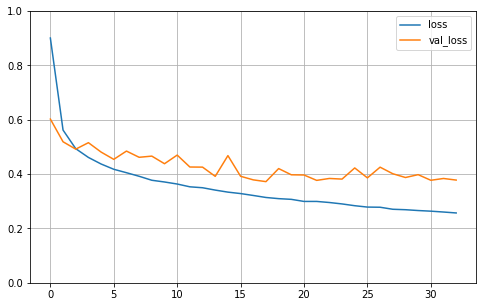

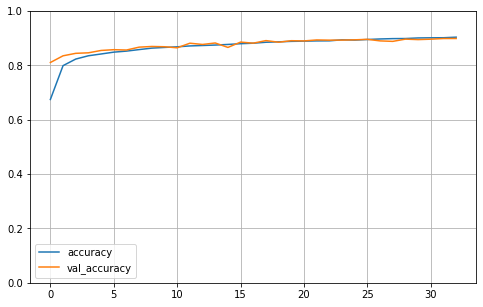

In [19]:
plot_learning_history(training_history)

In [20]:
mlp_model.evaluate(X_test, y_test)

313/313 [==============================] - 0s 725us/step - loss: 0.3944 - accuracy: 0.8879


[0.3943547308444977, 0.8878999948501587]

In [21]:
y_test_pred = np.argmax(mlp_model.predict(X_test), axis=-1)

Test Report
              precision    recall  f1-score   support

           0     0.8492    0.8110    0.8297      1000
           1     0.9899    0.9770    0.9834      1000
           2     0.8049    0.8290    0.8167      1000
           3     0.8660    0.9370    0.9001      1000
           4     0.8436    0.8250    0.8342      1000
           5     0.9758    0.9270    0.9508      1000
           6     0.7193    0.7020    0.7105      1000
           7     0.9027    0.9560    0.9286      1000
           8     0.9779    0.9730    0.9754      1000
           9     0.9534    0.9420    0.9477      1000

    accuracy                         0.8879     10000
   macro avg     0.8883    0.8879    0.8877     10000
weighted avg     0.8883    0.8879    0.8877     10000



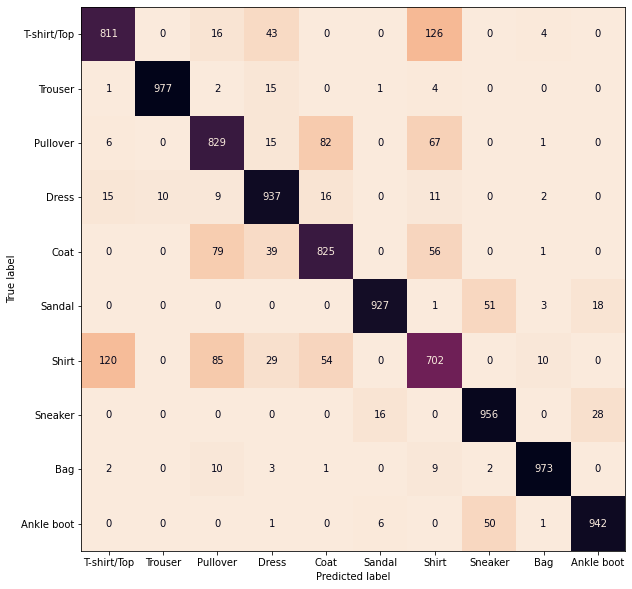

In [22]:
print('Test Report')
print(classification_report(y_test, y_test_pred, digits=4))

matrix = plot_confusion_matrix_by_predictions(y_test, y_test_pred, display_labels=label_names)
matrix.figure_.set_figheight(10)
matrix.figure_.set_figwidth(10)

In [23]:
## Chance Model
# Loss: 2.43648624420166
# Accuracy: 0.12780000269412994

## Dense(300, activation='relu'), Dense(100, activation='relu'), SGD
# Best Val Loss: 0.3154
# Best Val Accuracy: 0.8987
# Best Test Loss: 0.3189171850681305
# Best Test Accuracy: 0.8956999778747559

## Dense(300, activation='relu'), Dense(100, activation='relu'), Adam(lr=0.0005)
# Best Val Loss: 0.3054
# Best Val Accuracy: 0.8972
# Best Test Loss: 0.31720462441444397
# Best Test Accuracy: 0.8913999795913696

## Dense(300, activation='relu'), BatchNorm(), Dense(100, activation='relu'), BatchNorm(), Adam(lr=0.0005)
# Best Val Loss: 0.3020
# Best Val Accuracy: 0.8958
# Best Test Loss: 0.33810487389564514
# Best Test Accuracy: 0.8925999999046326

## Adam(lr=0.0005), Dense(300, activation='relu'), BatchNorm(), Dropout(0.2), Dense(100, activation='relu'), BatchNorm(), Dropout(0.2)
# Best Val Loss: 0.2882
# Best Val Accuracy: 0.8964
# Best Test Loss: 0.3012319505214691
# Best Test Accuracy: 0.8920000195503235

## Adam(lr=0.0005), batch_size=32, Dense(300, activation='relu'), BatchNorm(), Dropout(0.2), Dense(100, activation='relu'), BatchNorm(), Dropout(0.2), Dense(50, activation='relu'), BatchNorm(), Dropout(0.2)
# Best Val Loss: 0.2822
# Best Val Accuracy: 0.9010
# Best Test Loss: 0.29744410514831543
# Best Test Accuracy: 0.8920999765396118

## Adam(lr=0.0005), batch_size=64, Dense(300, activation='relu'), BatchNorm(), Dropout(0.2), Dense(100, activation='relu'), BatchNorm(), Dropout(0.2), Dense(50, activation='relu'), BatchNorm(), Dropout(0.2)
# Best Val Loss: 0.3215
# Best Val Accuracy: 0.9032
# Best Test Loss: 0.29807841777801514
# Best Test Accuracy: 0.8945000171661377

## RMSprop(), batch_size=32, Dense(300, activation='relu'), BatchNorm(), Dropout(0.2), Dense(100, activation='relu'), BatchNorm(), Dropout(0.2), Dense(50, activation='relu'), BatchNorm(), Dropout(0.2)
# Best Val Loss: 0.3024
# Best Val Accuracy: 0.8970
# Best Test Loss: 0.3157300651073456
# Best Test Accuracy: 0.8924000263214111

## RMSprop(), batch_size=256, Dense(300, activation='relu'), BatchNorm(), Dropout(0.2), Dense(100, activation='relu'), BatchNorm(), Dropout(0.2), Dense(50, activation='relu'), BatchNorm(), Dropout(0.2)
# Best Val Loss: 0.2886
# Best Val Accuracy: 0.9017
# Best Test Loss: 0.2969489097595215
# Best Test Accuracy: 0.8981000185012817

## Adam(lr=0.0005), batch_size=256, Dense(300, activation='relu'), BatchNorm(), Dropout(0.2), Dense(100, activation='relu'), BatchNorm(), Dropout(0.2), Dense(50, activation='relu'), BatchNorm(), Dropout(0.2)
# Best Val Loss: 0.2938
# Best Val Accuracy: 0.9023
# Best Test Loss: 0.29765433073043823
# Best Test Accuracy: 0.8996000289916992

## Nadam(lr=0.0005), batch_size=256, Dense(300, activation='selu'), AlphaDropout(0.2), Dense(100, activation='selu'), AlphaDropout(0.2), Dense(50, activation='selu'), AlphaDropout(0.2)
# Best Val Loss: 0.3629
# Best Val Accuracy: 0.9026
# Best Test Loss: 0.39967575669288635
# Best Test Accuracy: 0.8942999839782715

## Nadam(lr=0.001), batch_size=256, Dense(300, activation='selu', kernel_initializer='lecun_normal'), AlphaDropout(0.2), Dense(100, activation='selu', kernel_initializer='lecun_normal'), AlphaDropout(0.2), Dense(50, activation='selu', kernel_initializer='lecun_normal'), AlphaDropout(0.2)
# Best Val Loss: 0.4443
# Best Val Accuracy: 0.9081
# Best Test Loss: 0.5121541023254395
# Best Test Accuracy: 0.8996999859809875

### Error Analysis

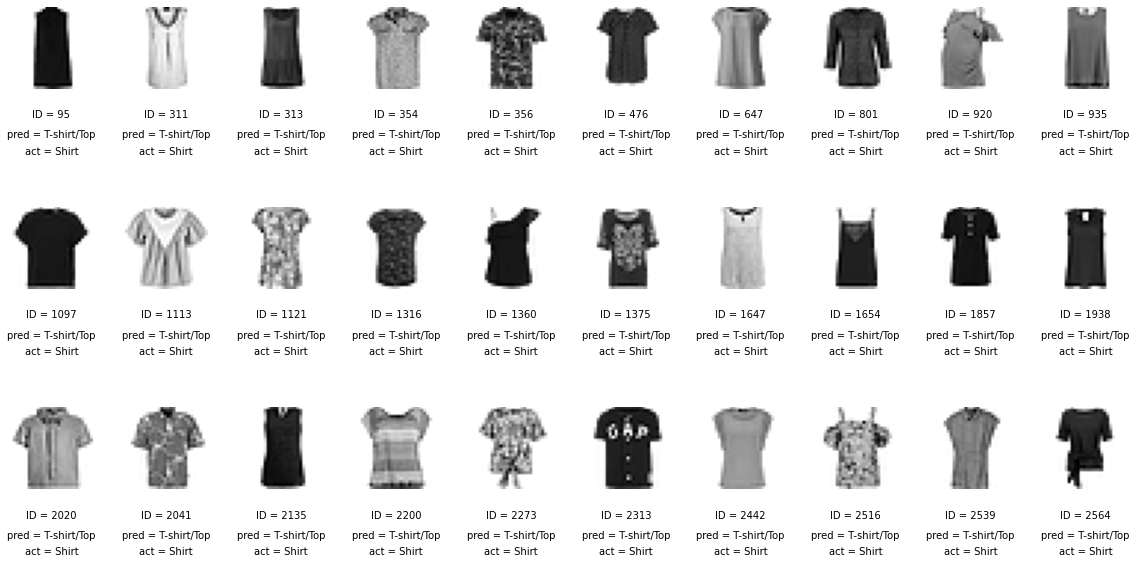

In [24]:
plot_misclassified_samples(y_test, y_test_pred, true_label=6, pred_label=0)

## CNN

In [25]:
X_train2d = X_train.to_numpy().reshape((-1, 28, 28))
y_train_onehot = to_categorical(y_train, label_num)

X_test2d = X_test.to_numpy().reshape((-1, 28, 28))
y_test_onehot = to_categorical(y_test, label_num)

X_train_val2d = X_train_val.to_numpy().reshape((-1, 28, 28))
y_train_val_onehot = to_categorical(y_train_val, label_num)

X_val2d = X_val.to_numpy().reshape((-1, 28, 28))
y_val_onehot = to_categorical(y_val, label_num)

In [26]:
cnn_input_layer = Input((28, 28, 1), name='input')

cnn = Conv2D(64, 7, activation='relu', padding='same', name='conv1_low_level')(cnn_input_layer)
cnn = MaxPool2D(2, name='pooling1')(cnn)

cnn = Conv2D(128, 3, activation='relu', padding='same', name='conv2_1_double')(cnn)
cnn = Conv2D(128, 3, activation='relu', padding='same', name='conv2_2_double')(cnn)
cnn = MaxPool2D(2, name='pooling2')(cnn)

cnn = Conv2D(256, 3, activation='relu', padding='same', name='conv3_1_double')(cnn)
cnn = Conv2D(256, 3, activation='relu', padding='same', name='conv3_2_double')(cnn)
cnn = MaxPool2D(2, name='pooling3')(cnn)

cnn = Flatten()(cnn)

cnn = Dense(128, activation='relu', name='dense1')(cnn)
cnn = Dropout(0.4, name='dropout1')(cnn)

cnn = Dense(64, activation='relu', name='dense2')(cnn)
cnn = Dropout(0.4, name='dropout2')(cnn)

cnn_output_layer = Dense(label_num, activation='softmax', name='dense_output')(cnn)

cnn_model = Model(cnn_input_layer, cnn_output_layer, name='CNN')

cnn_model.summary()

Model: "CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv1_low_level (Conv2D)     (None, 28, 28, 64)        3200      
_________________________________________________________________
pooling1 (MaxPooling2D)      (None, 14, 14, 64)        0         
_________________________________________________________________
conv2_1_double (Conv2D)      (None, 14, 14, 128)       73856     
_________________________________________________________________
conv2_2_double (Conv2D)      (None, 14, 14, 128)       147584    
_________________________________________________________________
pooling2 (MaxPooling2D)      (None, 7, 7, 128)         0         
_________________________________________________________________
conv3_1_double (Conv2D)      (None, 7, 7, 256)         295168  

In [27]:
optimizer = Nadam(lr=0.001)

cnn_model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy'],
)

In [28]:
early_stopping_callback = EarlyStopping(patience=15, restore_best_weights=True)

checkpoint_callback = ModelCheckpoint('checkpoints/fashion-cnn-classifier.h5', save_best_only=True)
tensorboard_callback = TensorBoardCallback(get_log_dir(), histogram_freq=1, write_graph=True, write_images=True)

cnn_training_history = cnn_model.fit(
    X_train_val2d, y_train_val_onehot, 
    validation_data=(X_val2d, y_val_onehot),
    epochs=200,
    batch_size=512,
    callbacks=[tensorboard_callback, checkpoint_callback, early_stopping_callback]
)

Epoch 1/200
94/94 [==============================] - 96s 1s/step - loss: 1.6815 - accuracy: 0.3845 - val_loss: 0.5472 - val_accuracy: 0.8066
Epoch 2/200
94/94 [==============================] - 91s 968ms/step - loss: 0.6244 - accuracy: 0.7797 - val_loss: 0.3889 - val_accuracy: 0.8589
Epoch 3/200
94/94 [==============================] - 94s 1s/step - loss: 0.4471 - accuracy: 0.8461 - val_loss: 0.3238 - val_accuracy: 0.8817
Epoch 4/200
94/94 [==============================] - 93s 990ms/step - loss: 0.3913 - accuracy: 0.8662 - val_loss: 0.3205 - val_accuracy: 0.8760
Epoch 5/200
94/94 [==============================] - 93s 994ms/step - loss: 0.3399 - accuracy: 0.8818 - val_loss: 0.2836 - val_accuracy: 0.8974
Epoch 6/200
94/94 [==============================] - 96s 1s/step - loss: 0.3098 - accuracy: 0.8924 - val_loss: 0.2657 - val_accuracy: 0.9031
Epoch 7/200
94/94 [==============================] - 95s 1s/step - loss: 0.2822 - accuracy: 0.9023 - val_loss: 0.2498 - val_accuracy: 0.9085
Epoc

### Evaluation

Best Val Loss: 0.2184
Best Val Accuracy: 0.9274


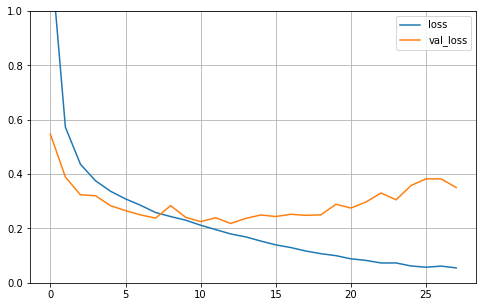

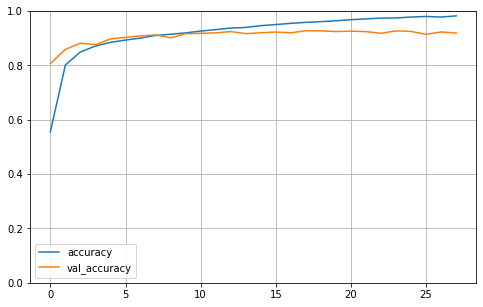

In [37]:
plot_learning_history(cnn_training_history)

In [38]:
cnn_model.evaluate(X_test2d, y_test_onehot)

313/313 [==============================] - 5s 17ms/step - loss: 0.2160 - accuracy: 0.9243


[0.21597687900066376, 0.9243000149726868]

Test Report
              precision    recall  f1-score   support

           0     0.8570    0.8930    0.8746      1000
           1     0.9737    0.9990    0.9862      1000
           2     0.8896    0.8780    0.8837      1000
           3     0.9456    0.9210    0.9331      1000
           4     0.8449    0.9150    0.8785      1000
           5     0.9909    0.9770    0.9839      1000
           6     0.8136    0.7290    0.7690      1000
           7     0.9523    0.9780    0.9650      1000
           8     0.9939    0.9850    0.9895      1000
           9     0.9798    0.9680    0.9738      1000

    accuracy                         0.9243     10000
   macro avg     0.9241    0.9243    0.9237     10000
weighted avg     0.9241    0.9243    0.9237     10000



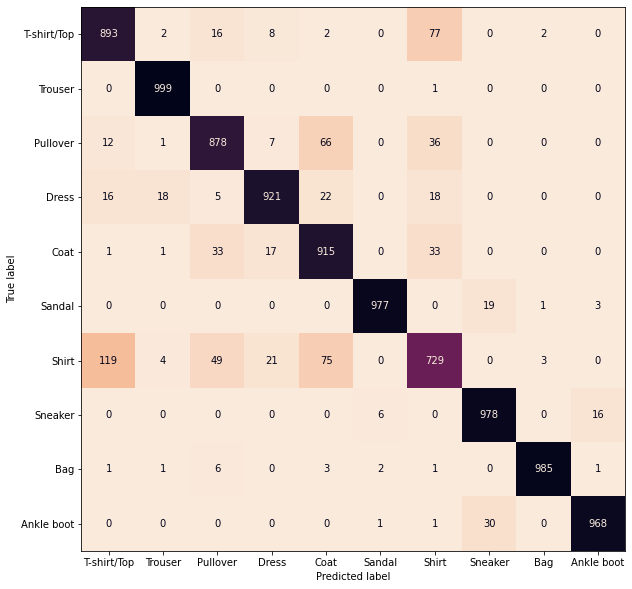

In [39]:
y_test_pred = np.argmax(cnn_model.predict(X_test2d), axis=-1)

print('Test Report')
print(classification_report(y_test, y_test_pred, digits=4))

matrix = plot_confusion_matrix_by_predictions(y_test, y_test_pred, display_labels=label_names)
matrix.figure_.set_figheight(10)
matrix.figure_.set_figwidth(10)

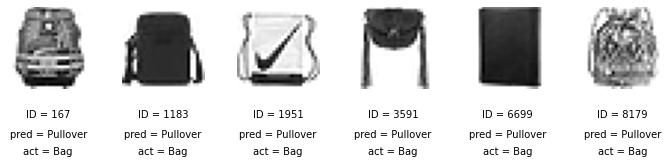

In [43]:
plot_misclassified_samples(y_test, y_test_pred, true_label=8, pred_label=2)

In [48]:
def plot_conv_output(model, layer_name, test_input):
    model_layers = dict([(layer.name, layer) for layer in model.layers])

    inspection_model = Model(inputs=model.inputs, outputs=model_layers[layer_name].output)

    sample_feature_maps = inspection_model.predict(test_input)

    for feature_maps in sample_feature_maps:
        fig = plt.figure(figsize=(25, 25))
        fig.subplots_adjust(hspace=0.4, wspace=0.4)

        feature_maps = tensorflow.transpose(feature_maps, [2, 1, 0])

        for i, feature_map in enumerate(feature_maps):
            ax = fig.add_subplot(30, 10, i + 1)
            ax.axis('off')

            ax.imshow(feature_map, cmap='binary')

    return fig

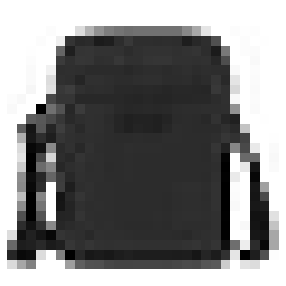

In [45]:
sample_image = X_test2d[1183]

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1, 1, 1)
ax.axis('off')

ax.imshow(sample_image, cmap='binary')

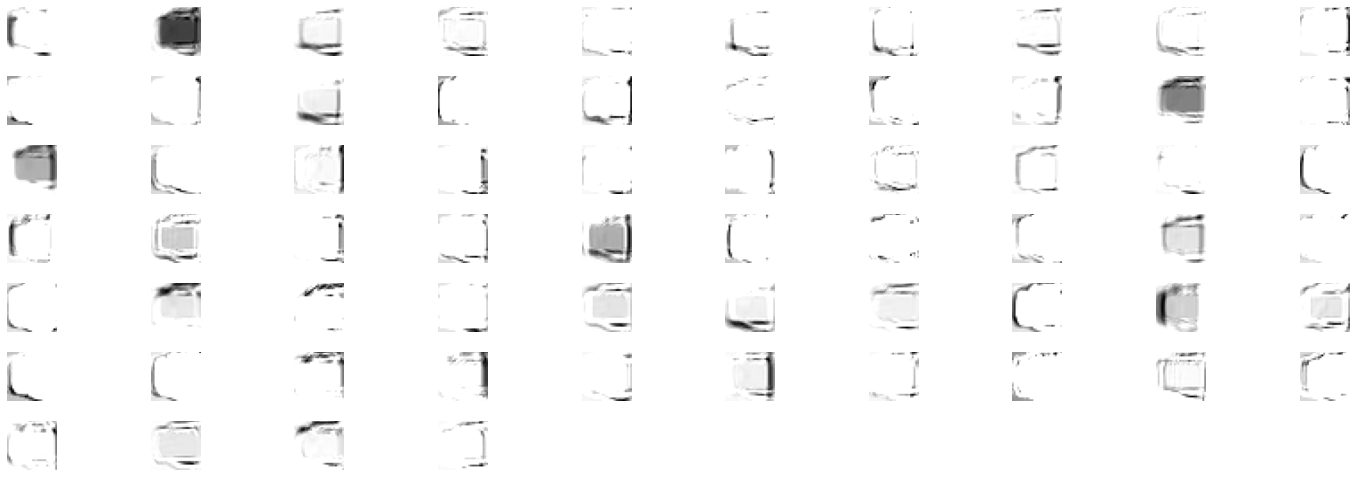

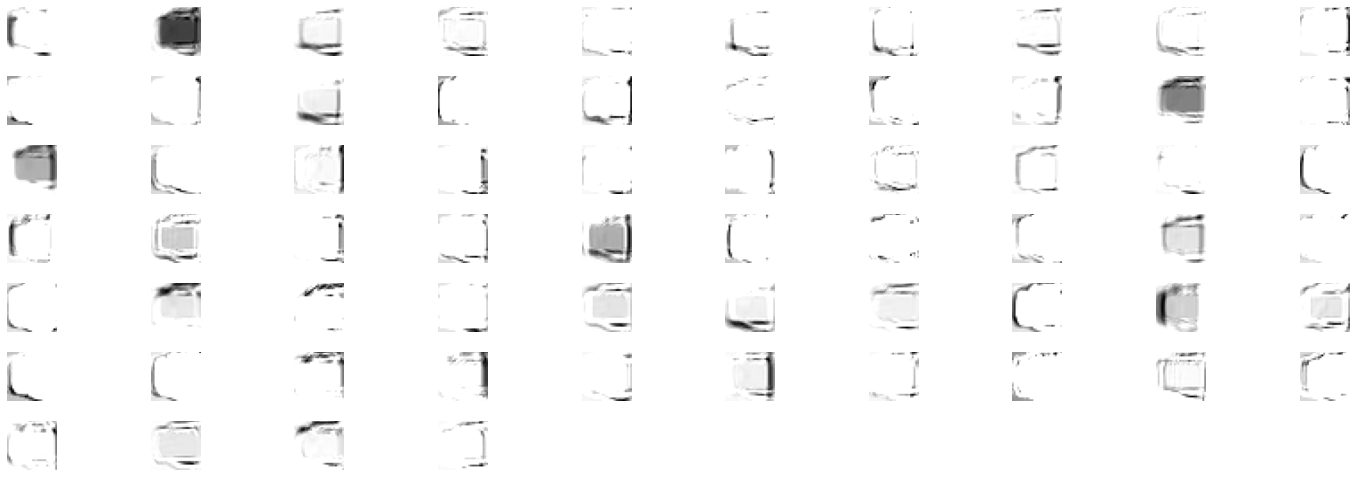

In [46]:
plot_conv_output(cnn_model, 'conv1_low_level', np.array([sample_image]))

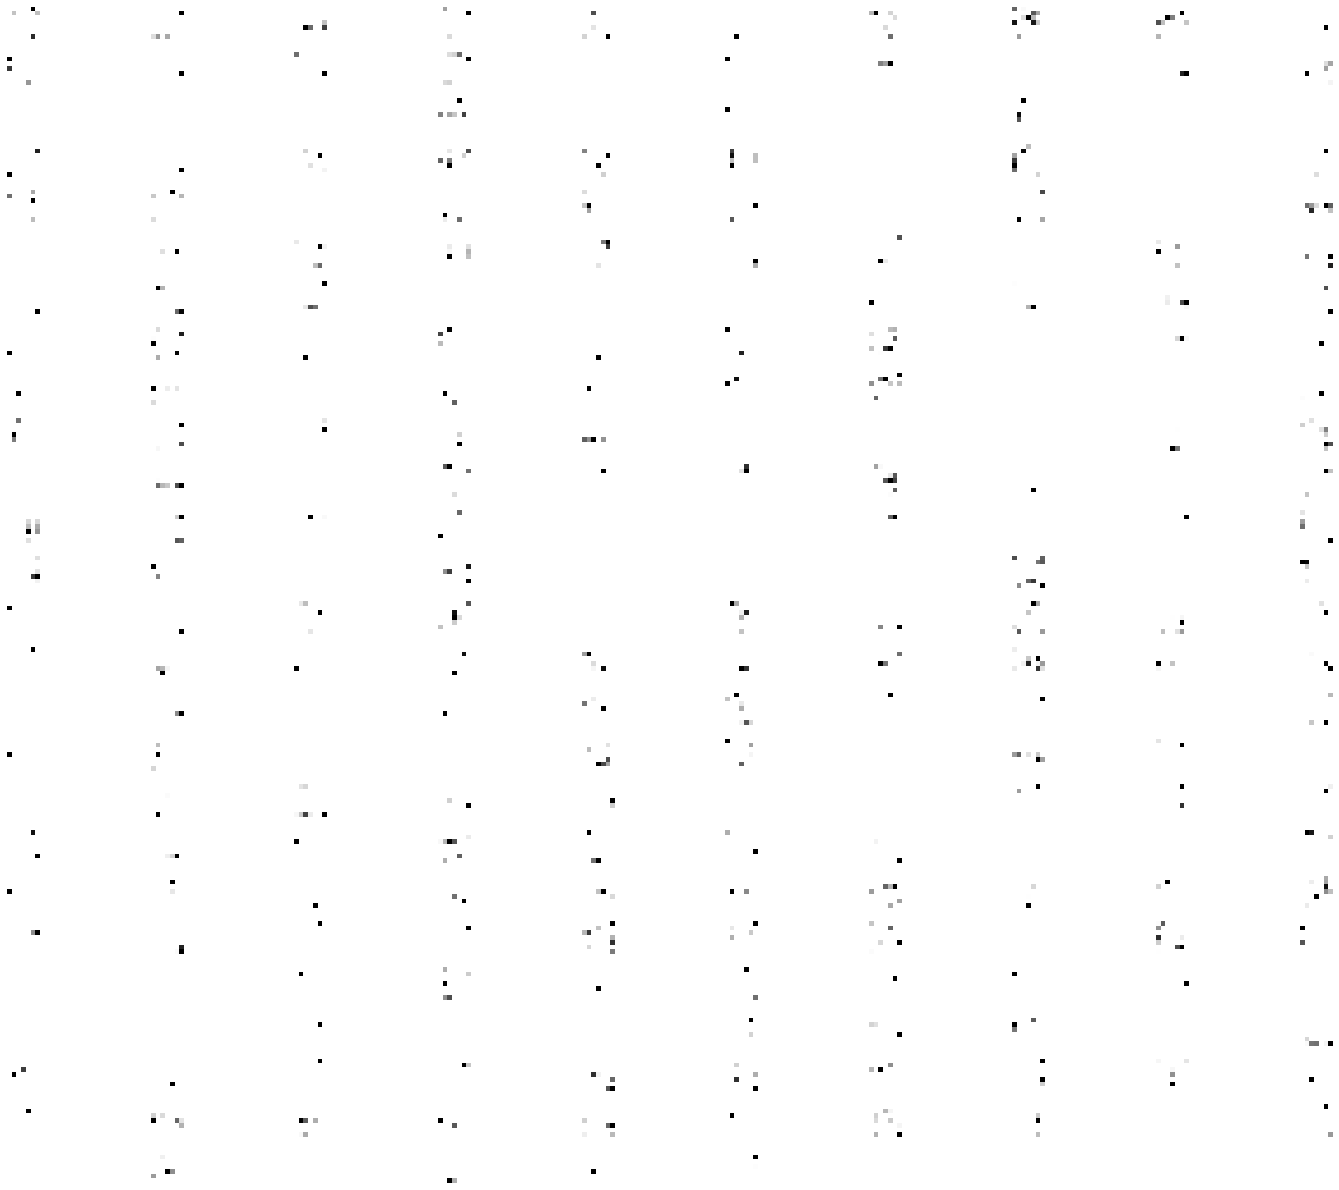

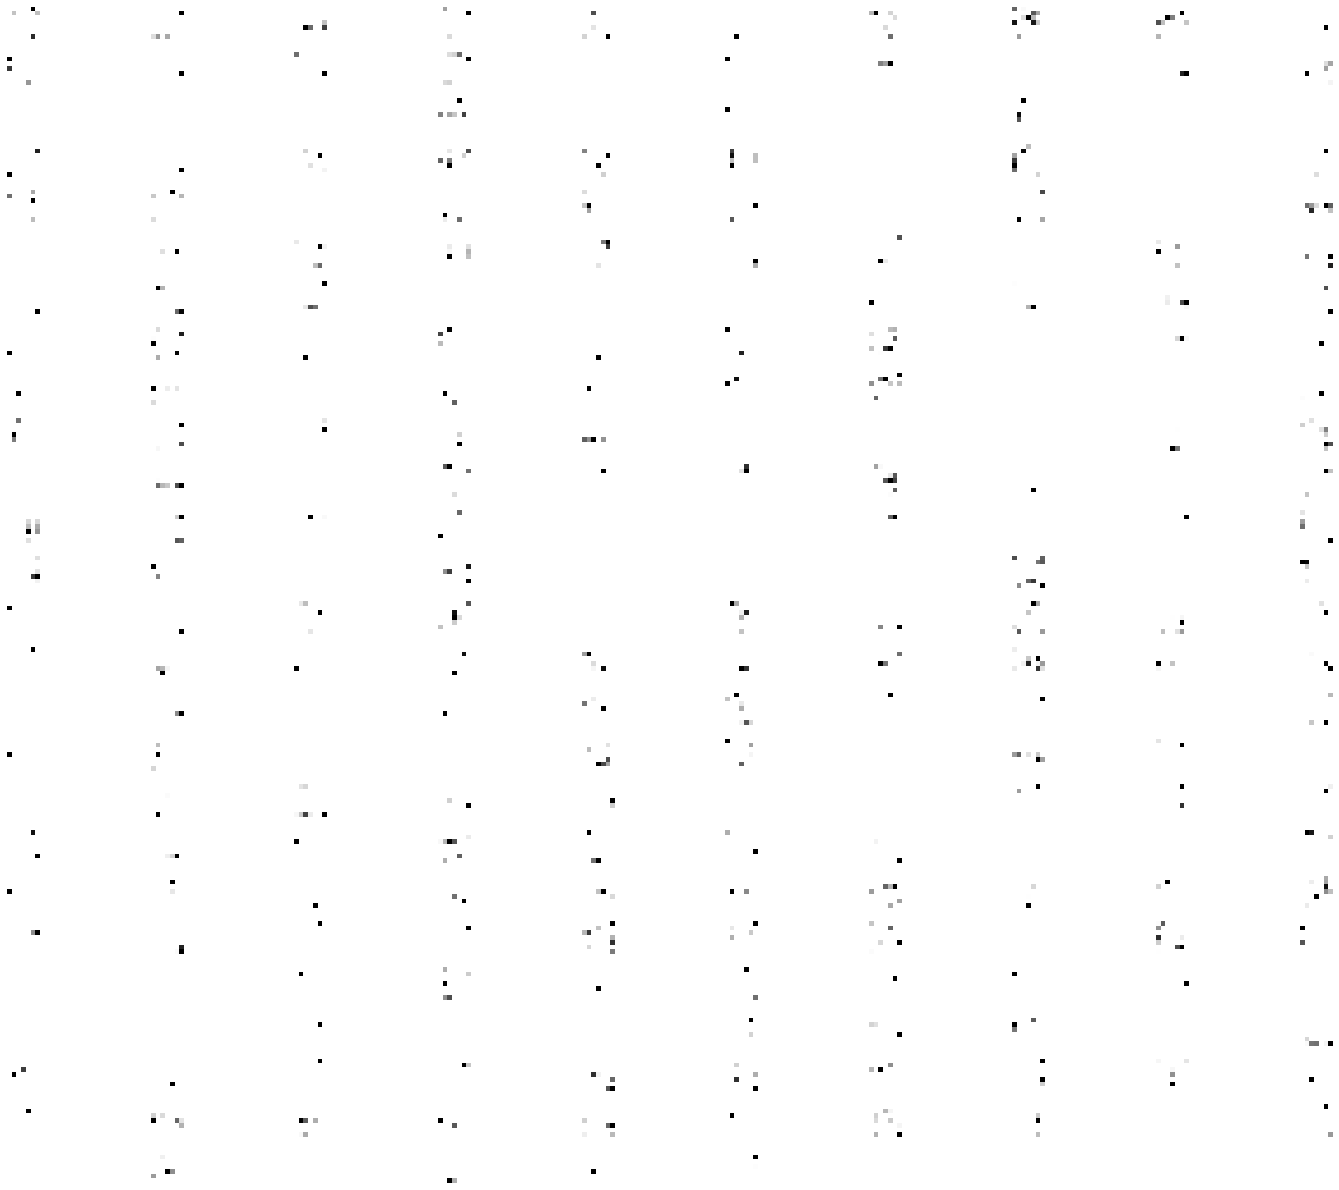

In [49]:
plot_conv_output(cnn_model, 'conv3_2_double', np.array([sample_image]))

### Experiment Notes

#### Baseline CNN
- Val Loss: 0.2382
- Test Loss: 0.2433 
- Val Accuracy: 0.9224
- Test Accuracy: 0.9136

```
cnn = Conv2D(64, 7, activation='relu', name='conv1_low_level')(cnn_input_layer)
cnn = MaxPool2D(2)(cnn)

cnn = Conv2D(128, 3, activation='relu', name='conv2_1_double')(cnn)
cnn = Conv2D(128, 3, activation='relu', name='conv2_2_double')(cnn)

cnn = Flatten()(cnn)

cnn = Dense(128, activation='relu', name='dense1')(cnn)
cnn = Dropout(0.2, name='dropout1')(cnn)
cnn = Dense(64, activation='relu', name='dense2')(cnn)
cnn = Dropout(0.2, name='dropout2')(cnn)

Nadam(lr=0.001)
batch_size=256
```

### 3 Conv Layer NN
- Val Loss: 0.2181
- Test Loss: 0.2269
- Val Accuracy: 0.9247
- Test Accuracy: 0.9174

```
cnn_input_layer = Input((28, 28, 1), name='input')

cnn = Conv2D(64, 7, activation='relu', padding='same', name='conv1_low_level')(cnn_input_layer)
cnn = MaxPool2D(2, name='pooling1')(cnn)

cnn = Conv2D(128, 3, activation='relu', padding='same', name='conv2_1_double')(cnn)
cnn = Conv2D(128, 3, activation='relu', padding='same', name='conv2_2_double')(cnn)
cnn = MaxPool2D(2, name='pooling2')(cnn)

cnn = Conv2D(256, 3, activation='relu', padding='same', name='conv3_1_double')(cnn)
cnn = Conv2D(256, 3, activation='relu', padding='same', name='conv3_2_double')(cnn)
cnn = MaxPool2D(2, name='pooling3')(cnn)

cnn = Flatten()(cnn)

cnn = Dense(128, activation='relu', name='dense1')(cnn)
cnn = Dropout(0.2, name='dropout1')(cnn)

cnn = Dense(64, activation='relu', name='dense2')(cnn)
cnn = Dropout(0.2, name='dropout2')(cnn)

cnn_output_layer = Dense(label_num, activation='softmax', name='dense_output')(cnn)

Nadam(lr=0.001)
batch_size=256
```

### CNN: 3Conv + Droupout (0.4) + 512 batch_size
- Val Loss: 0.2172
- Test Loss: 0.21914228796958923
- Val Accuracy: 0.9273
- Test Accuracy: 0.9253000020980835

```
cnn_input_layer = Input((28, 28, 1), name='input')

cnn = Conv2D(64, 7, activation='relu', padding='same', name='conv1_low_level')(cnn_input_layer)
cnn = MaxPool2D(2, name='pooling1')(cnn)

cnn = Conv2D(128, 3, activation='relu', padding='same', name='conv2_1_double')(cnn)
cnn = Conv2D(128, 3, activation='relu', padding='same', name='conv2_2_double')(cnn)
cnn = MaxPool2D(2, name='pooling2')(cnn)

cnn = Conv2D(256, 3, activation='relu', padding='same', name='conv3_1_double')(cnn)
cnn = Conv2D(256, 3, activation='relu', padding='same', name='conv3_2_double')(cnn)
cnn = MaxPool2D(2, name='pooling3')(cnn)

cnn = Flatten()(cnn)

cnn = Dense(128, activation='relu', name='dense1')(cnn)
cnn = Dropout(0.4, name='dropout1')(cnn)

cnn = Dense(64, activation='relu', name='dense2')(cnn)
cnn = Dropout(0.4, name='dropout2')(cnn)

cnn_output_layer = Dense(label_num, activation='softmax', name='dense_output')(cnn)

cnn_model = Model(cnn_input_layer, cnn_output_layer, name='CNN')

Nadam(lr=0.001)
batch_size=512
```